In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

log_dir = "logs/" + "dcgan_fashion_mnist/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(log_dir)

# tf.debugging.experimental.enable_dump_debug_info(log_dir, tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)


In [49]:
BATCH_SIZE = 32
EPOCHS = 2
CHANNELS = 1
LATENT_DIMS = 100
NUMBER_OF_CLASSES = 10

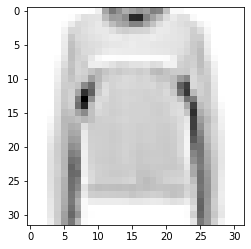

In [25]:
def convert_data_to_ds(images, labels):
#     print(images, labels)
    images = tf.cast(images, tf.float32)
    images = images / tf.reduce_max(images)
    images = tf.expand_dims(images, axis=-1)
    images = tf.image.resize(images, [32,32])
    return (images, labels)

train_data, valid_data = tf.keras.datasets.fashion_mnist.load_data()
# print("train_images:", train_data[0].shape)
# print("train_labels:", train_data[1].shape)

train_ds = tf.data.Dataset.from_tensor_slices(train_data).shuffle(1000).map(convert_data_to_ds).batch(BATCH_SIZE)
valid_ds = tf.data.Dataset.from_tensor_slices(valid_data).shuffle(1000).map(convert_data_to_ds).batch(BATCH_SIZE)

plt.imshow(next(iter(valid_ds))[0][0,:,:,0], cmap="gray_r")

In [35]:
def build_generator(latent_dims=100):
    input_labels = tf.keras.layers.Input(shape=[1], name="gen_labels")
    y = tf.keras.layers.Embedding(input_dim=10, output_dim=50, name="embed")(input_labels)
    y = tf.keras.layers.Dense(8*8*1)(y)
    y = tf.keras.layers.Reshape(target_shape=[8,8,1])(y)

    inputs_latent = tf.keras.layers.Input(shape=[latent_dims], name="latent_points")
    x = tf.keras.layers.Dense(8*8*128)(inputs_latent)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Reshape(target_shape=[8,8,128])(x)
    merge = tf.keras.layers.Concatenate(name="merge")([x, y])
    x = tf.keras.layers.Conv2DTranspose(64, kernel_size=(4,4), strides=2, padding="same")(merge)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=(4,4), strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(CHANNELS, kernel_size=(4,4), padding="same", activation="sigmoid")(x)
    
    generated_images=x
    model = tf.keras.models.Model(inputs=[inputs_latent, input_labels], outputs=[generated_images])
    return model

generator_model = build_generator(LATENT_DIMS)
print("generator output shape (array form):", generator_model([tf.random.uniform([2, LATENT_DIMS]), tf.constant([1,3])]).shape)
print("generator output shape (dict form):", generator_model({"latent_points": tf.random.uniform([2, LATENT_DIMS]), "gen_labels":tf.constant([1,3])}).shape)
# tf.keras.utils.plot_model(generator_model, show_shapes=True)

generator output shape (array form): (2, 32, 32, 1)
generator output shape (dict form): (2, 32, 32, 1)


In [40]:
def build_discriminator():
    input_labels = tf.keras.layers.Input(shape=[1], name="disc_labels")
    y = tf.keras.layers.Embedding(input_dim=10, output_dim=50)(input_labels)
    y = tf.keras.layers.Dense(32*32*CHANNELS)(y)
    y = tf.keras.layers.Reshape([32, 32, CHANNELS])(y)
    
    input_images = tf.keras.layers.Input(shape=[32, 32, CHANNELS], name="disc_images")
    x = tf.keras.layers.Concatenate()([input_images, y])
    x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding="same", activation="selu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding="same", activation="selu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding="same", activation="selu", name="conv128")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    
    classes = x
    model = tf.keras.models.Model(inputs=[input_images, input_labels], outputs=[classes])
    return model

disc_model = build_discriminator()
print("discriminator output shape:", disc_model([tf.random.uniform([BATCH_SIZE, 32, 32, CHANNELS]), tf.cast(tf.random.uniform([BATCH_SIZE])*10, tf.int16)]).shape)
print("discriminator output shape:", disc_model([tf.random.uniform([BATCH_SIZE, 32, 32, CHANNELS]), tf.cast(tf.random.uniform([BATCH_SIZE])*10, tf.int16)]).shape)
# tf.keras.utils.plot_model(disc_model, show_shapes=True)

discriminator output shape: (32, 1)
discriminator output shape: (32, 1)


In [41]:
generator_optimizer = tf.keras.optimizers.Adam()
disc_optimizer = tf.keras.optimizers.Adam()
xentropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [42]:
def Discriminator_Loss(real_inputs, generated_inputs):
    real_loss = xentropy_loss(tf.ones_like(real_inputs), real_inputs)
    generated_loss = xentropy_loss(tf.zeros_like(generated_inputs), generated_inputs)
    return real_loss + generated_loss

def Generator_Loss(generated_inputs):
    gen_loss = xentropy_loss(tf.ones_like(generated_inputs), generated_inputs)
    return gen_loss


In [44]:
@tf.function
def train_step(epoch, inputs):
    images, labels = inputs
    batch_size = tf.shape(images)[0]
    white_noise = tf.random.normal([batch_size, LATENT_DIMS])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_model([white_noise, labels], training=True)
        
        real_output = disc_model([images, labels], training=True)
        fake_output = disc_model([generated_images, labels], training=True)
        
        gen_loss = Generator_Loss(fake_output)
        disc_loss = Discriminator_Loss(real_output, fake_output)
        
    gen_gradients = gen_tape.gradient(gen_loss, generator_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, disc_model.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gen_gradients, generator_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, disc_model.trainable_variables))

#     print("images:", images.shape)
#     print("generated_images:", generated_images.shape)

    with summary_writer.as_default():
        tf.summary.scalar("gen_loss", gen_loss, step=epoch)
        tf.summary.scalar("disc_loss", disc_loss, step=epoch)

    return gen_loss, disc_loss

epoch  0
0 gen loss: 2.4240575 disc loss: 0.99635035
600 gen loss: 1.6994727 disc loss: 1.041355
1200 gen loss: 1.0816844 disc loss: 1.475781
1800 gen loss: 1.4661337 disc loss: 1.1017342

tf.Tensor(
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3
 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9], shape=(100,), dtype=int32)


C:\Users\ikuchin\AppData\Local\Continuum\miniconda3\envs\tf23\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


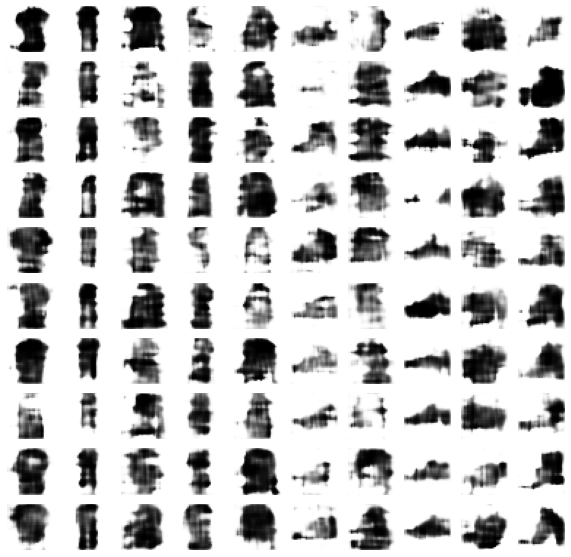

epoch  1
0 gen loss: 2.120271 disc loss: 0.6983671
600 gen loss: 1.5297223 disc loss: 0.9583377
1200 gen loss: 3.1148117 disc loss: 0.71562564
1800 gen loss: 2.8395295 disc loss: 0.9692985

tf.Tensor(
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3
 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9], shape=(100,), dtype=int32)


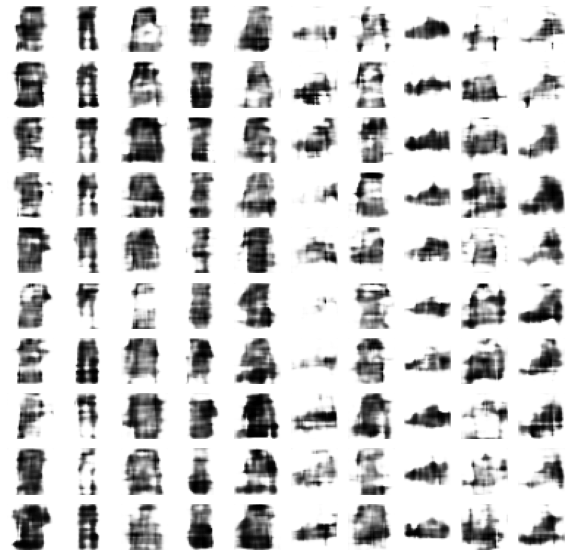

In [64]:
def draw_progress_pictures():
    NUMBER_OF_PICTURE_TO_DRAW = NUMBER_OF_CLASSES ** 2
    NUMBER_OF_ROWS = tf.cast(tf.sqrt(NUMBER_OF_PICTURE_TO_DRAW + 0.00001), tf.float16).numpy()
#     print(NUMBER_OF_ROWS)
    white_noise = tf.random.normal([NUMBER_OF_PICTURE_TO_DRAW, LATENT_DIMS])
    labels = tf.range(NUMBER_OF_PICTURE_TO_DRAW) % NUMBER_OF_CLASSES
    print(labels)
    generated_images = generator_model([white_noise, labels])
    
    plt.figure(figsize=(10, 10))
    for i in range(NUMBER_OF_PICTURE_TO_DRAW):
        plt.subplot(NUMBER_OF_ROWS, NUMBER_OF_ROWS, i + 1)
        plt.axis(False)
        plt.imshow(generated_images[i], cmap="gray_r")

for epoch in range(EPOCHS):
    print("epoch ", epoch)
    for idx, inputs in enumerate(train_ds):
        gen_loss, disc_loss = train_step(epoch, inputs)
        if(idx%600==0):
            print(idx, "gen loss:", gen_loss.numpy(), "disc loss:", disc_loss.numpy())
    print()
    
    draw_progress_pictures()
    plt.show()

In [ ]:
generator_model.trainable_variables[0]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np

x = np.array([-2.2, -1.4, -.8, .2, .4, .8, 1.2, 2.2, 2.9, 4.6])
y = np.array([0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

logr = LogisticRegression(solver='lbfgs')
logr.fit(x.reshape(-1, 1), y)

y_pred = logr.predict_proba(x.reshape(-1, 1))[:, 1].ravel()
loss = log_loss(y, y_pred)

print('x = {}'.format(x))
print('y = {}'.format(y))
print('p(y) = {}'.format(np.round(y_pred, 2)))
print('Log Loss / Cross Entropy = {:.4f}'.format(loss))

In [24]:
tf.losses.BinaryCrossentropy(from_logits=False)([0.], [0.])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0>

In [ ]:
log_loss([0., 1.], [0.5, 0.5])